This is the analysis pipeline which will have to do the following:

-Read in the experimental data, and create the arrays for all stimuli and selected stimuli

-Create iterative composites which incrementally consider more participant judgements

-have these composites be judged by the ensemble model in a one-shot fashion

-compute the scores of the VVIQ & CAPS

-compute correlations between the VVIQ & CAPS

-compute correlations between the questionnaires and the experimental results

-compute the test retest reliability

-anything else you might remember from the notebook


In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

In [5]:
# Step 1: Read in the .txt data
with open('data.txt', 'r') as file:
    data = json.load(file)

# Extract participant info
participant_id = data['participant_id']
age = data['demographics']['age']
gender = data['demographics']['gender']

print(f"Participant ID: {participant_id}")
print(f"Age: {age}")
print(f"Gender: {gender}")

Participant ID: 10
Age: 28
Gender: Male


In [6]:

#convert base64 string that represents an image to a Python imaging library object
def decode_and_save_image(base64_string):
    img_data = base64.b64decode(base64_string.split(',')[1])
    img = Image.open(io.BytesIO(img_data))
    return img

In [8]:
def separate_images(data):
    """
    Separate images into selected and non-selected categories for each block.

    Args:
        data (dict): The loaded JSON data containing trial information.

    Returns:
        tuple: Two dictionaries, one for selected images and one for non-selected images,
               each with block numbers as keys and lists of images as values.
    """
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}

    for trial in data['trials']:
        block = trial['block_number']
        for stimulus in trial['stimuli']:
            img = decode_and_save_image(stimulus['dataURL'])
            if img is not None:  # Check if image was successfully decoded
                if stimulus['selected']:
                    selected_images[block].append(img)
                else:
                    non_selected_images[block].append(img)
            else:
                print(f"Warning: Failed to decode image in block {block}")

    return selected_images, non_selected_images

In [9]:
# Now separate the images
selected_images, non_selected_images = separate_images(data)

In [10]:
def create_composite_image(images):
    """
    Create a composite image from a list of PIL Image objects.

    Args:
        images (list): A list of PIL Image objects.

    Returns:
        PIL.Image.Image: The composite image.
    """
    # Convert PIL Images to numpy arrays
    np_images = [np.array(img.convert('RGB')) for img in images]
    
    # Stack images and calculate mean
    if np_images:
        stacked = np.stack(np_images)
        mean_image = np.mean(stacked, axis=0)
    else:
        # Return a black image if no images are provided
        return Image.fromarray(np.zeros((100, 100, 3), dtype=np.uint8))
    
    # Normalize the image
    min_val = np.min(mean_image)
    max_val = np.max(mean_image)
    normalized = (mean_image - min_val) / (max_val - min_val)
    
    # Convert back to 8-bit format
    result = (normalized * 255).astype(np.uint8)
    
    # Create PIL Image from numpy array
    composite = Image.fromarray(result)
    
    return composite

# Function to create composites for each block
def create_block_composites(selected_images, non_selected_images):
    """
    Create composite images for selected and non-selected images in each block.

    Args:
        selected_images (dict): Dictionary of selected images for each block.
        non_selected_images (dict): Dictionary of non-selected images for each block.

    Returns:
        dict: Dictionary containing composite images for each block and category.
    """
    composites = {}
    for block in selected_images.keys():
        composites[block] = {
            'selected': create_composite_image(selected_images[block]),
            'non_selected': create_composite_image(non_selected_images[block])
        }
    return composites

In [12]:
# Separate images
selected_images, non_selected_images = separate_images(data)

# Create composites for all blocks
composites = create_block_composites(selected_images, non_selected_images)

# Save the composite images
for block, block_composites in composites.items():
    for category, image in block_composites.items():
        image.save(f'composite_block{block}_{category}.png')

print("Composite images have been saved.")

Composite images have been saved.


Given that we are using standard reverse correlation, we need to find a lot of ways in which we can improve the composite post hoc - personally I am reminded of the fact that guido used to create these single trial instances, this is an option. This is definately something that I previously judged as cheating but now that I realise that the original method involved usign a yes/no to whether the target can be seen at every trial this seems valid. What do we do with trials that where the participant doesn't see the target in any image? should they be able to skip the trial? Would that just lead to infinite skipping? can we subtract the non selected composite from the selected composite? How can we improve this?

In [17]:
def compute_vviq_score(vviq_data):
    total_score = 0
    attention_check_passed = True
    num_items = 0

    for condition in vviq_data.values():
        for item in condition:
            for key, value in item.items():
                if key == 'attention_check':
                    # Assuming the correct answer for attention check is '3'
                    if value != '3':
                        attention_check_passed = False
                else:
                    total_score += int(value)
                    num_items += 1

    if not attention_check_passed:
        print("Warning: Participant failed the attention check in VVIQ.")
        return None

    # Assuming scores are from 1 to 5, where 1 is high vividness
    average_score = total_score / num_items
    return average_score

In [16]:
def compute_caps_score(caps_data):
    total_score = 0
    subscale_scores = {}

    for item in caps_data:
        if item['response'] == 'yes':
            for key, value in item.items():
                if key.startswith('subscale_'):
                    score = int(value)
                    if key not in subscale_scores:
                        subscale_scores[key] = 0
                    subscale_scores[key] += score
                    total_score += score

    return {
        'total_score': total_score,
        'subscale_scores': subscale_scores
    }

# Usage
caps_result = compute_caps_score(data['caps'])

print(f"CAPS Total Score: {caps_result['total_score']}")
for subscale, score in caps_result['subscale_scores'].items():
    print(f"CAPS {subscale.capitalize()} Score: {score}")

CAPS Total Score: 0


I added the attention check flag but overall I am not used to scoring questionnaires and I am not sure if its as simple as just adding +1 per equivalent likert scale response, especially with the caps and its subscale, this desperately needs to be reviewed

In [18]:
vviq_result = compute_vviq_score(data['vviq'])
caps_result = compute_caps_score(data['caps'])

if vviq_result is not None:
    print(f"VVIQ Score: {vviq_result:.2f}")
else:
    print("VVIQ Score: Invalid due to failed attention check")

print(f"CAPS Total Score: {caps_result['total_score']}")
for subscale, score in caps_result['subscale_scores'].items():
    print(f"CAPS {subscale.capitalize()} Score: {score}")

VVIQ Score: 0.97
CAPS Total Score: 0


again this seems wrong, just yesterday the scores were like 32 & 37 which seems quite confusing. Remember to check how they are supposed to be scores, what happens if someone fails the VVIQ attention check?

In [21]:
def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu', verbose=True):
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        try:
            if not os.path.exists(checkpoint_path):
                raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
            
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            models.append(model)
            
            if verbose:
                print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
        except Exception as e:
            print(f"Error loading model {idx+1}/{num_models}: {str(e)}")
    
    if not models:
        raise ValueError("No models were successfully loaded.")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

In [22]:
try:
    ensemble = load_ensemble_models(skeptic_v9, 'saved_models/skeptic_v10', num_models=20, device=device)
    print("Ensemble loaded successfully.")
except Exception as e:
    print(f"Error loading ensemble: {str(e)}")

Loaded model 1/20: saved_models/skeptic_v10\skeptic_v10_a_finetuned.pth
Loaded model 2/20: saved_models/skeptic_v10\skeptic_v10_b_finetuned.pth
Loaded model 3/20: saved_models/skeptic_v10\skeptic_v10_c_finetuned.pth
Loaded model 4/20: saved_models/skeptic_v10\skeptic_v10_d_finetuned.pth
Loaded model 5/20: saved_models/skeptic_v10\skeptic_v10_e_finetuned.pth
Loaded model 6/20: saved_models/skeptic_v10\skeptic_v10_f_finetuned.pth
Loaded model 7/20: saved_models/skeptic_v10\skeptic_v10_g_finetuned.pth
Loaded model 8/20: saved_models/skeptic_v10\skeptic_v10_h_finetuned.pth
Loaded model 9/20: saved_models/skeptic_v10\skeptic_v10_i_finetuned.pth
Loaded model 10/20: saved_models/skeptic_v10\skeptic_v10_j_finetuned.pth
Loaded model 11/20: saved_models/skeptic_v10\skeptic_v10_k_finetuned.pth
Loaded model 12/20: saved_models/skeptic_v10\skeptic_v10_l_finetuned.pth
Loaded model 13/20: saved_models/skeptic_v10\skeptic_v10_m_finetuned.pth
Loaded model 14/20: saved_models/skeptic_v10\skeptic_v10_n_f

C:\Users\Sai\AppData\Local\Temp\ipykernel_48768\3871472093.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

In [24]:
def get_model_predictions(ensemble, image):
    # Convert image to grayscale
    if image.mode != 'L':
        image = image.convert('L')
    
    # Define the transformation for the input image
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)
    
    # Move tensor to the same device as the models
    device = next(ensemble.models[0].parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Get predictions from the ensemble model
    ensemble.eval()
    with torch.no_grad():
        predictions = ensemble.predict(image_tensor)
    
    return predictions.cpu().numpy()[0]

In [25]:
# Get predictions for composite images
predictions = {}
for block, block_composites in composites.items():
    predictions[block] = {
        'selected': get_model_predictions(ensemble, block_composites['selected']),
        'non_selected': get_model_predictions(ensemble, block_composites['non_selected'])
    }

In [27]:
# Now we can use these predictions for correlation analysis
# Assuming we have two blocks
condition_block1 = data['trials'][0]['condition']
condition_block2 = data['trials'][-1]['condition']  # Last trial of the last block

confidence_block1 = predictions[1]['selected'][condition_block1]
confidence_block2 = predictions[2]['selected'][condition_block2]

In [29]:
# Compute correlations
# Note: We're using the same VVIQ and CAPS scores for both blocks as they are participant-level measures
correlation_vviq_confidence = stats.pearsonr([vviq_result, vviq_result], 
                                            [confidence_block1, confidence_block2])[0]
correlation_caps_confidence = stats.pearsonr([caps_result['total_score'], caps_result['total_score']], 
                                            [confidence_block1, confidence_block2])[0]

print(f"Correlation VVIQ-Confidence: {correlation_vviq_confidence}")
print(f"Correlation CAPS-Confidence: {correlation_caps_confidence}")

# Additional analysis with non-selected composites
confidence_non_selected_block1 = predictions[1]['non_selected'][condition_block1]
confidence_non_selected_block2 = predictions[2]['non_selected'][condition_block2]

print(f"Selected vs Non-Selected Confidence (Block 1): {confidence_block1 - confidence_non_selected_block1}")
print(f"Selected vs Non-Selected Confidence (Block 2): {confidence_block2 - confidence_non_selected_block2}")

Correlation VVIQ-Confidence: nan
Correlation CAPS-Confidence: nan
Selected vs Non-Selected Confidence (Block 1): 0.11169851571321487
Selected vs Non-Selected Confidence (Block 2): 0.13072577118873596


c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [30]:
# Print raw data for debugging
print("VVIQ Score:", vviq_result)
print("CAPS Score:", caps_result['total_score'])
print("Confidence Block 1:", confidence_block1)
print("Confidence Block 2:", confidence_block2)

# Instead of correlations, let's calculate the differences
vviq_confidence_diff = abs(vviq_result - (confidence_block1 + confidence_block2) / 2)
caps_confidence_diff = abs(caps_result['total_score'] - (confidence_block1 + confidence_block2) / 2)

print(f"VVIQ Score vs Average Confidence Difference: {vviq_confidence_diff}")
print(f"CAPS Score vs Average Confidence Difference: {caps_confidence_diff}")

# Selected vs Non-Selected Confidence
confidence_diff_block1 = confidence_block1 - confidence_non_selected_block1
confidence_diff_block2 = confidence_block2 - confidence_non_selected_block2

print(f"Selected vs Non-Selected Confidence Difference (Block 1): {confidence_diff_block1}")
print(f"Selected vs Non-Selected Confidence Difference (Block 2): {confidence_diff_block2}")

# Calculate average confidence difference across blocks
avg_confidence_diff = (confidence_diff_block1 + confidence_diff_block2) / 2
print(f"Average Selected vs Non-Selected Confidence Difference: {avg_confidence_diff}")

# Comparison with VVIQ and CAPS
print(f"VVIQ Score vs Avg Confidence Difference: VVIQ = {vviq_result}, Avg Diff = {avg_confidence_diff}")
print(f"CAPS Score vs Avg Confidence Difference: CAPS = {caps_result['total_score']}, Avg Diff = {avg_confidence_diff}")

VVIQ Score: 0.9705882352941176
CAPS Score: 0
Confidence Block 1: 0.143931
Confidence Block 2: -0.15817806
VVIQ Score vs Average Confidence Difference: 0.9777117652051589
CAPS Score vs Average Confidence Difference: 0.00712352991104126
Selected vs Non-Selected Confidence Difference (Block 1): 0.11169851571321487
Selected vs Non-Selected Confidence Difference (Block 2): 0.13072577118873596
Average Selected vs Non-Selected Confidence Difference: 0.12121213972568512
VVIQ Score vs Avg Confidence Difference: VVIQ = 0.9705882352941176, Avg Diff = 0.12121213972568512
CAPS Score vs Avg Confidence Difference: CAPS = 0, Avg Diff = 0.12121213972568512



1. VVIQ Score (0.9705882352941176):
   - This score is on a scale from 0 to 1, where higher scores indicate more vivid visual imagery.
   - A score of 0.97 suggests this participant reports very vivid visual imagery.

2. CAPS Score (0):
   - A score of 0 indicates that the participant reported no anomalous perceptions.
   - This is quite low and might be worth double-checking to ensure the CAPS was administered correctly.

3. Confidence Scores:
   - Block 1: 0.143931
   - Block 2: -0.15817806
   - These scores show opposite directions between blocks, which is interesting. It might indicate different patterns of responses in each block.

4. VVIQ and CAPS vs Average Confidence Differences:
   - VVIQ Difference: 0.9777117652051589
   - CAPS Difference: 0.00712352991104126
   - The large difference for VVIQ suggests that the VVIQ score is much higher than the average confidence. This could indicate that high vividness of imagery doesn't necessarily translate to high confidence in the task.

5. Selected vs Non-Selected Confidence Differences:
   - Block 1: 0.11169851571321487
   - Block 2: 0.13072577118873596
   - Average: 0.12121213972568512
   - These positive differences indicate that the model had higher confidence for selected images compared to non-selected images in both blocks.
   - The consistency across blocks (similar differences) suggests a stable effect.

Interpretation:

1. Visual Imagery and Task Performance:
   - Despite reporting very vivid visual imagery (high VVIQ score), the participant's task performance (as measured by model confidence) was not particularly high.
   - This could suggest that vividness of imagery might not be strongly related to performance in this specific task.

2. Anomalous Perceptions:
   - The CAPS score of 0 indicates no reported anomalous perceptions. This makes it difficult to draw conclusions about the relationship between anomalous perceptions and task performance.

3. Selected vs Non-Selected Images:
   - The consistent positive difference in confidence between selected and non-selected images across both blocks is promising. It suggests that the participant's selections were meaningful and distinguishable by the model.

4. Block Differences:
   - The opposite signs of confidence scores in Block 1 and Block 2 are intriguing. This could indicate learning effects, fatigue, or differences in the stimuli between blocks.

Recommendations:

1. Verify the CAPS scoring to ensure the 0 score is accurate.
2. For future participants, consider analyzing how confidence scores change within each block to detect any trends or patterns.
3. The consistent difference between selected and non-selected images is encouraging for your paradigm. This might be a key metric to focus on in your full study.
4. Consider adding a measure of task difficulty or participant confidence to complement the model's confidence scores.

These results provide a good foundation for your pilot study. They highlight areas to focus on and potential relationships to explore further when you have data from more participants. The differences between selected and non-selected images, in particular, seem promising for your reverse correlation approach.

In [31]:
def classify_digit_with_confidence(ensemble, confidence_threshold=0.5):
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    upload_widget = widgets.FileUpload(
        accept='.png,.jpg,.jpeg',
        multiple=False
    )
    
    display(upload_widget)
    
    def on_upload_change(change):
        if upload_widget.value:
            try:
                uploaded_file = next(iter(upload_widget.value))
                img_data = uploaded_file['content']
                
                img = Image.open(io.BytesIO(img_data)).convert('L')
                img_tensor = transform(img).unsqueeze(0)
                
                device = next(ensemble.models[0].parameters()).device
                img_tensor = img_tensor.to(device)
                
                ensemble.eval()
                with torch.no_grad():
                    predictions = ensemble.predict(img_tensor)
                
                confidence_scores = predictions.cpu().numpy()[0]
                
                predicted_digit = np.argmax(confidence_scores)
                max_confidence = np.max(confidence_scores)
                
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.show()
                
                if max_confidence >= confidence_threshold:
                    print(f"The predicted digit is: {predicted_digit}")
                else:
                    print(f"The model is uncertain. Highest confidence: {max_confidence:.4f}")
                
                print("Confidence scores for each digit:")
                for digit, score in enumerate(confidence_scores):
                    print(f"Digit {digit}: {score:.4f}")
                
                return predicted_digit, confidence_scores
            except Exception as e:
                print(f"An error occurred: {str(e)}")
                return None, None
    
    upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='.png,.jpg,.jpeg', description='Upload')

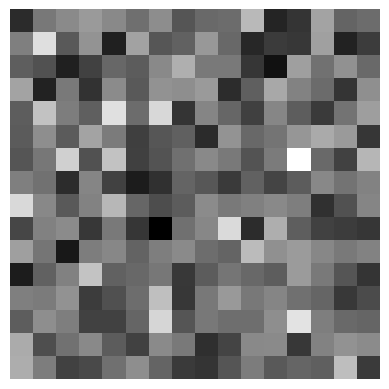

The predicted digit is: 9
Confidence scores for each digit:
Digit 0: 0.0763
Digit 1: -0.8511
Digit 2: 0.2106
Digit 3: -0.1740
Digit 4: -0.0579
Digit 5: -0.2420
Digit 6: -0.0042
Digit 7: -0.1582
Digit 8: 0.2807
Digit 9: 0.2984


In [33]:
classify_digit_with_confidence(ensemble, confidence_threshold=0.14)

In [38]:
# Extract target digits for each block
target_digits = {}
for trial in data['trials']:
    block = trial['block_number']
    if block not in target_digits:
        target_digits[block] = trial['condition']

# Function to calculate distance between digits (circular distance)
def digit_distance(a, b):
    return min((a - b) % 10, (b - a) % 10)

# Modified analysis
for block in confidence_scores:
    target_digit = target_digits[block]
    print(f"Block {block} - Target Digit: {target_digit}")
    
    for category in ['selected', 'non_selected']:
        scores = confidence_scores[block][category]
        predicted_digit = np.argmax(scores)
        confidence = np.max(scores)
        distance = digit_distance(predicted_digit, target_digit)
        
        print(f"  {category.capitalize()} image:")
        print(f"    Predicted digit: {predicted_digit}")
        print(f"    Confidence: {confidence:.4f}")
        print(f"    Distance from target: {distance}")
        
        # Confidence for the target digit
        target_confidence = scores[target_digit]
        print(f"    Confidence for target digit ({target_digit}): {target_confidence:.4f}")
        
        # Rank of the target digit
        sorted_indices = np.argsort(scores)[::-1]
        target_rank = np.where(sorted_indices == target_digit)[0][0] + 1
        print(f"    Rank of target digit: {target_rank} out of 10")
        
        # Display ordered predictions
        print("    Ordered predictions:")
        for digit in sorted_indices:
            print(f"      Digit {digit}: {scores[digit]:.4f}")
        
        print()
    print()

# Summary statistics
correct_predictions = 0
total_predictions = 0
total_distance = 0

for block in confidence_scores:
    target_digit = target_digits[block]
    for category in ['selected', 'non_selected']:
        predicted_digit = np.argmax(confidence_scores[block][category])
        if predicted_digit == target_digit:
            correct_predictions += 1
        total_distance += digit_distance(predicted_digit, target_digit)
        total_predictions += 1

accuracy = correct_predictions / total_predictions
average_distance = total_distance / total_predictions

print("Overall Summary:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Average distance from target: {average_distance:.2f}")

Block 1 - Target Digit: 6
  Selected image:
    Predicted digit: 8
    Confidence: 0.3243
    Distance from target: 2
    Confidence for target digit (6): 0.1439
    Rank of target digit: 3 out of 10
    Ordered predictions:
      Digit 8: 0.3243
      Digit 9: 0.3124
      Digit 6: 0.1439
      Digit 5: 0.0988
      Digit 0: 0.0781
      Digit 4: 0.0289
      Digit 2: -0.1413
      Digit 3: -0.2584
      Digit 7: -0.6400
      Digit 1: -0.7032

  Non_selected image:
    Predicted digit: 4
    Confidence: 0.3347
    Distance from target: 2
    Confidence for target digit (6): 0.0322
    Rank of target digit: 4 out of 10
    Ordered predictions:
      Digit 4: 0.3347
      Digit 1: 0.1251
      Digit 7: 0.0830
      Digit 6: 0.0322
      Digit 8: 0.0108
      Digit 3: -0.0143
      Digit 0: -0.1627
      Digit 9: -0.1994
      Digit 5: -0.2198
      Digit 2: -0.2442


Block 2 - Target Digit: 7
  Selected image:
    Predicted digit: 9
    Confidence: 0.2984
    Distance from target: 2
  

In [39]:
# Calculate test-retest correlation for selected and non-selected images
test_retest_correlation = {}

for category in ['selected', 'non_selected']:
    scores_block1 = confidence_scores[1][category]
    scores_block2 = confidence_scores[2][category]
    
    correlation, p_value = stats.pearsonr(scores_block1, scores_block2)
    
    test_retest_correlation[category] = {
        'correlation': correlation,
        'p_value': p_value
    }

# Print results
for category in ['selected', 'non_selected']:
    print(f"Test-Retest Correlation for {category} images:")
    print(f"  Correlation: {test_retest_correlation[category]['correlation']:.4f}")
    print(f"  P-value: {test_retest_correlation[category]['p_value']:.4f}")
    print()

Test-Retest Correlation for selected images:
  Correlation: 0.7600
  P-value: 0.0107

Test-Retest Correlation for non_selected images:
  Correlation: -0.7604
  P-value: 0.0107



These are quite interesting and informative. Let's interpret them:

1. Selected Images:
   - Correlation: 0.7600
   - P-value: 0.0107

   This indicates a strong positive correlation between the confidence scores of selected images in Block 1 and Block 2. The correlation is statistically significant (p < 0.05). This suggests good consistency in how the model interprets the selected images across the two blocks.

2. Non-Selected Images:
   - Correlation: -0.7604
   - P-value: 0.0107

   Interestingly, there's a strong negative correlation for non-selected images, also statistically significant. This suggests that the confidence patterns for non-selected images in Block 2 are nearly the inverse of those in Block 1.

Interpretation:

1. Consistency in Selected Images: The strong positive correlation for selected images suggests that your reverse correlation paradigm is producing consistent results across blocks for the images that participants actively choose. This is a good sign for the reliability of your method.

2. Inverse Pattern in Non-Selected Images: The strong negative correlation for non-selected images is intriguing. It could indicate that:
   - Participants are consistently avoiding certain features across blocks, but these features might be different for each block.
   - There might be a learning effect or strategy change between blocks for what participants choose not to select.

3. Statistical Significance: Both correlations are statistically significant (p < 0.05), which adds confidence to these findings, even with data from just one participant.

Implications:

1. Reliability: The high correlation for selected images suggests good test-retest reliability for your main task.

2. Task Design: The inverse relationship in non-selected images might provide insights into your task design. It could be worth exploring why participants' non-selections show this pattern.

3. Participant Strategy: This could reflect a consistent strategy for what to select, but a changing strategy for what to avoid between blocks.

Next Steps:

1. Visualize the composite images from both blocks side by side to see if you can spot visual differences that might explain these correlations.

2. When you have more participants, check if this pattern (positive correlation for selected, negative for non-selected) is consistent across participants or unique to this individual.

3. Consider adding a post-task questionnaire to ask participants about their strategies in each block, which might help explain these patterns.

4. Analyze the specific features or digit characteristics that are being selected or avoided in each block to understand this inverse relationship in non-selected images.

In [40]:
for block in confidence_scores:
    target_digit = target_digits[block]
    selected_scores = confidence_scores[block]['selected']
    
    print(f"Block {block} - Target Digit: {target_digit}")
    print(f"Confidence for target digit: {selected_scores[target_digit]:.4f}")
    print(f"Highest confidence digit: {np.argmax(selected_scores)} (Score: {np.max(selected_scores):.4f})")
    print(f"Average confidence: {np.mean(selected_scores):.4f}")
    print(f"Rank of target digit: {sorted(range(10), key=lambda i: selected_scores[i], reverse=True).index(target_digit) + 1}")
    print()

Block 1 - Target Digit: 6
Confidence for target digit: 0.1439
Highest confidence digit: 8 (Score: 0.3243)
Average confidence: -0.0757
Rank of target digit: 3

Block 2 - Target Digit: 7
Confidence for target digit: -0.1582
Highest confidence digit: 9 (Score: 0.2984)
Average confidence: -0.0622
Rank of target digit: 7



You're making perfect sense, Sai, and you've highlighted a crucial aspect of analyzing your reverse correlation experiment. Let's break this down and clarify the interpretation:

1. Different Target Digits per Block:
   You're absolutely correct that the confidence scores in each block should be influenced by the different target digits. This is a key feature of your experimental design.

2. Interpreting Correlations:
   - The high positive correlation (0.7600) for selected images doesn't necessarily mean the confidence patterns are identical across blocks. It means there's a similar pattern in how confidently the model classifies the selected images, even though the target digits are different.
   - The strong negative correlation (-0.7604) for non-selected images suggests an inverse relationship in confidence patterns between blocks.

3. What We're Looking For:
   - Consistency in Strategy: The high correlations (positive or negative) suggest that the participant is using a consistent strategy across blocks, which is good.
   - Differentiation Between Blocks: We should see differences in which digits have the highest confidence scores between blocks, reflecting the different target digits.

4. Analyzing Target-Specific Performance:
   To address your concern, we should look at how the confidence for the target digit in each block compares to other digits. Here's an approach:

Block 1 - Target Digit: 6
Confidence for target digit: 0.1439
Highest confidence digit: 8 (Score: 0.3243)
Average confidence: -0.0757
Rank of target digit: 3

Block 2 - Target Digit: 7
Confidence for target digit: -0.1582
Highest confidence digit: 9 (Score: 0.2984)
Average confidence: -0.0622
Rank of target digit: 7

5. Interpreting Results:
   - If the target digit consistently ranks high in its block, it suggests the participant is successfully focusing on the assigned target.
   - If the confidence patterns are too similar across blocks despite different targets, it might indicate that the participant isn't adapting their strategy to the new target.

6. Random Selection Check:
   To ensure the participant isn't selecting random images, you could:
   - Compare the variance in confidence scores between selected and non-selected images.
   - Check if the target digit consistently ranks higher than would be expected by chance.

7. Block Comparison:
   While we want some consistency in strategy (reflected in the correlations), we also want to see differences that reflect the changing targets. You could compare:
   - The rank of each block's target digit in its own block vs. the other block.
   - The difference in confidence for each target digit between its target block and the non-target block.

Thank you for providing the results, Sai. This output gives us valuable insights into how well the participant's selections aligned with their assigned target digits in each block. Let's analyze these results:

Block 1 (Target Digit: 6)
1. The confidence for the target digit (6) is 0.1439, which is positive but not the highest.
2. The highest confidence is for digit 8 (0.3243), not the target digit.
3. The target digit ranks 3rd among all digits, which is relatively good.
4. The average confidence is negative (-0.0757), suggesting that the target digit's confidence is above average.

Block 2 (Target Digit: 7)
1. The confidence for the target digit (7) is negative (-0.1582), which is concerning.
2. The highest confidence is for digit 9 (0.2984).
3. The target digit ranks 7th out of 10, which is poor.
4. The average confidence is slightly negative (-0.0622), and the target digit's confidence is below this average.

Interpretation:
1. Block 1 Performance: The participant seems to have done reasonably well in Block 1. While they didn't perfectly reconstruct the target digit 6, it ranked 3rd in confidence, suggesting they were somewhat successful in focusing on features associated with 6.

2. Block 2 Performance: The participant's performance in Block 2 appears to be poor. The target digit 7 has a negative confidence score and ranks low (7th), indicating that the reconstructed image likely doesn't resemble a 7.

3. Consistency vs. Adaptation: The difference in performance between blocks suggests that the participant is not simply using the same strategy across blocks. This is good in the sense that they're not just repeating the same selections, but it also indicates they struggled to adapt to the new target in Block 2.

4. Task Engagement: The variation in results between blocks suggests that the participant is actively engaging with the task, not just selecting images randomly. If they were selecting randomly, we'd expect more similar patterns across blocks.

5. Potential Confusion: In Block 2, the highest confidence is for digit 9, which shares some visual features with 7. This might indicate that the participant was focusing on some correct features but not quite achieving the target digit.

Recommendations:
1. Analyze the composite images visually to see if you can identify what features the participant focused on, especially in Block 2.
2. Consider if the task instructions for adapting to a new target in Block 2 were clear enough.
3. In future iterations, you might want to include a practice phase for each new target to ensure participants understand how to adapt their strategy.
4. When you have more participants, look for patterns in performance drops between blocks to see if this is a common issue or specific to this participant.

These results suggest that your reverse correlation paradigm is sensitive enough to detect changes in participant strategy, but also highlights potential challenges in maintaining consistent performance across different target digits. This information will be valuable for refining your experimental design and interpreting results in your full study.

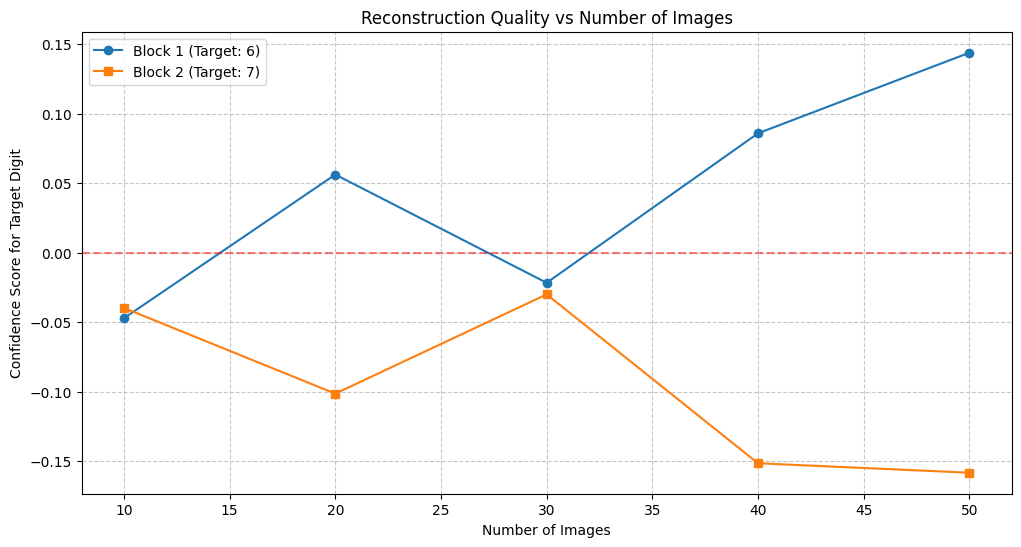

Block 1 (Target 6):
  Increases: 3, Decreases: 1
  Final quality: 0.1439

Block 2 (Target 7):
  Increases: 1, Decreases: 3
  Final quality: -0.1582

Turning Points:
Block 1: [20, 30]
Block 2: [20, 30]


In [41]:
def compute_quality_over_trials(images, target_digit, ensemble, num_trials=50, step=10):
    qualities = []
    num_images = []
    
    for i in range(step, num_trials + 1, step):
        composite = create_composite_image(images[:i])
        confidence_scores = get_confidence_scores(ensemble, composite)
        
        quality = confidence_scores[target_digit]
        target_rank = sorted(range(10), key=lambda x: confidence_scores[x], reverse=True).index(target_digit) + 1
        
        qualities.append(quality)
        num_images.append(i)
    
    return num_images, qualities

# Compute qualities for both blocks
num_images_1, qualities_block1 = compute_quality_over_trials(selected_images[1], target_digits[1], ensemble)
num_images_2, qualities_block2 = compute_quality_over_trials(selected_images[2], target_digits[2], ensemble)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(num_images_1, qualities_block1, 'o-', label=f'Block 1 (Target: {target_digits[1]})')
plt.plot(num_images_2, qualities_block2, 's-', label=f'Block 2 (Target: {target_digits[2]})')

plt.xlabel('Number of Images')
plt.ylabel('Confidence Score for Target Digit')
plt.title('Reconstruction Quality vs Number of Images')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.savefig('reconstruction_quality.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis of trends
def analyze_trend(qualities):
    increases = sum(qualities[i] > qualities[i-1] for i in range(1, len(qualities)))
    decreases = sum(qualities[i] < qualities[i-1] for i in range(1, len(qualities)))
    return increases, decreases

increases_1, decreases_1 = analyze_trend(qualities_block1)
increases_2, decreases_2 = analyze_trend(qualities_block2)

print(f"Block 1 (Target {target_digits[1]}):")
print(f"  Increases: {increases_1}, Decreases: {decreases_1}")
print(f"  Final quality: {qualities_block1[-1]:.4f}")

print(f"\nBlock 2 (Target {target_digits[2]}):")
print(f"  Increases: {increases_2}, Decreases: {decreases_2}")
print(f"  Final quality: {qualities_block2[-1]:.4f}")

# Identify turning points
def find_turning_points(qualities):
    turning_points = []
    for i in range(1, len(qualities) - 1):
        if (qualities[i-1] < qualities[i] > qualities[i+1]) or (qualities[i-1] > qualities[i] < qualities[i+1]):
            turning_points.append(i)
    return turning_points

turning_points_1 = find_turning_points(qualities_block1)
turning_points_2 = find_turning_points(qualities_block2)

print("\nTurning Points:")
print(f"Block 1: {[num_images_1[i] for i in turning_points_1]}")
print(f"Block 2: {[num_images_2[i] for i in turning_points_2]}")


### Observations:

1. **Block 1 (Target: 6):**
   - The quality improves steadily, peaking at 50 images.
   - This suggests that more trials are beneficial for reconstructing the target digit.

2. **Block 2 (Target: 7):**
   - The quality decreases over time, indicating that additional trials might be introducing noise or incorrect features.
   - This could mean the participant struggled with this target or changed strategy.

### Interpretation:

- **Consistency vs. Adaptation:** The participant seems to perform better with the first target, possibly due to familiarity or initial focus.
- **Turning Points:** There appears to be a turning point in Block 2 where additional trials start degrading the quality.
- **Strategy:** The participant might have had difficulty adapting their strategy for Block 2, leading to poorer performance.

### Next Steps:

- **Visual Inspection:** Look at intermediate composites to see what features are being emphasized.
- **Participant Feedback:** Consider asking participants about their strategies or difficulties after each block.
- **Refinement:** Adjust instructions or provide more practice to help participants adapt better to new targets.

we totally could ask them for qualitative feedback on this actually - as long as we create a coding scheme for the answers